# Adapted from <https://computing.llnl.gov/projects/zfp/zfp-and-derivatives>

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
x = y = np.linspace(-1, 1, 1024)
Y, X = np.meshgrid(y, x, indexing="ij")

In [3]:
x[1] - x[0]

np.float64(0.0019550342130987275)

In [4]:
2 / 1023

0.0019550342130987292

In [5]:
U = np.power(X**2 + Y**2, 3 / 2) / 9

In [6]:
DU = np.sqrt(X**2 + Y**2)

In [7]:
def plot_DU(DU):
    fig, ax = plt.subplots()

    ax.imshow(DU, cmap="RdBu_r", origin="lower", extent=(-1, 1, -1, 1))
    ax.contour(X, Y, DU, levels=10, colors="lightgrey", alpha=0.25)
    ax.set_aspect("equal")

    plt.show()

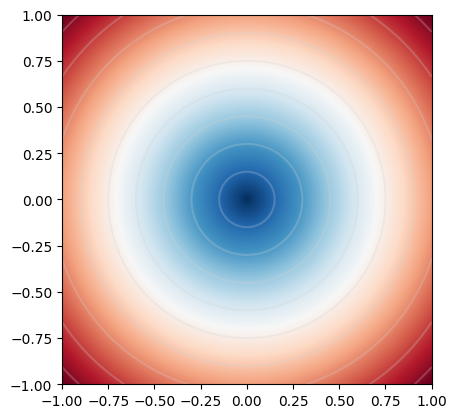

In [8]:
plot_DU(DU)

In [9]:
DU_np = np.gradient(np.gradient(U, axis=0), axis=0) + np.gradient(
    np.gradient(U, axis=1), axis=1
)

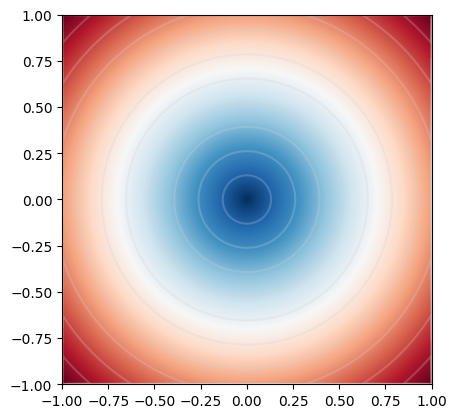

In [10]:
plot_DU(DU_np)

In [11]:
from numcodecs_wasm_zfp import Zfp

In [12]:
zfp = Zfp(mode="fixed-rate", rate=5.5)

In [13]:
U_zfp = zfp.decode(zfp.encode(U))

In [14]:
DU_zfp = np.gradient(np.gradient(U_zfp, axis=0), axis=0) + np.gradient(
    np.gradient(U_zfp, axis=1), axis=1
)

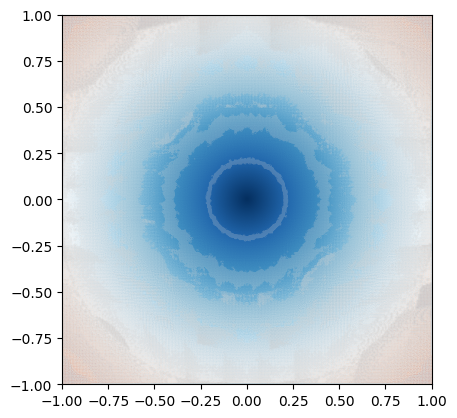

In [15]:
plot_DU(DU_zfp)

In [16]:
np.amax(np.abs(U_zfp - U))

np.float64(3.36917364224254e-06)

In [17]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [18]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=3e-6),
    ],
)

In [19]:
U_sg = sg.decode(sg.encode(U))

In [20]:
DU_sg = np.gradient(np.gradient(U_sg, axis=0), axis=0) + np.gradient(
    np.gradient(U_sg, axis=1), axis=1
)

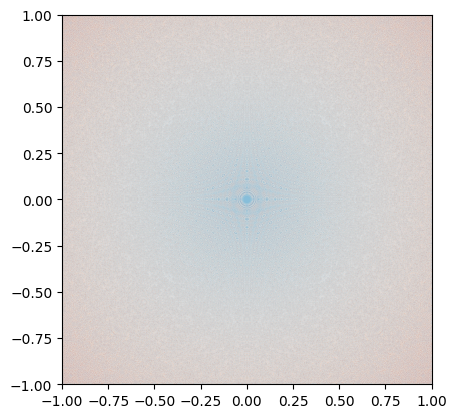

In [21]:
plot_DU(DU_sg)

In [22]:
sg_qoi = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="findiff(x, order=2, accuracy=2, type=0, dx=2/1023, axis=0)+findiff(x, order=2, accuracy=2, type=0, dx=2/1023, axis=1)",
            neighbourhood=[
                dict(axis=0, before=1, after=1, boundary="edge"),
                dict(axis=1, before=1, after=1, boundary="edge"),
            ],
            type="abs",
            eb=1.0,
        ),
    ],
)

In [23]:
sg_qoi._safeguards.safeguards[0]._qoi_expr

1046529*X[0, 1]/4 + 1046529*X[1, 0]/4 - 1046529*X[1, 1] + 1046529*X[1, 2]/4 + 1046529*X[2, 1]/4

In [24]:
U_sg_qoi = sg_qoi.decode(sg_qoi.encode(U))

In [25]:
DU_sg_qoi = np.gradient(np.gradient(U_sg_qoi, axis=0), axis=0) + np.gradient(
    np.gradient(U_sg_qoi, axis=1), axis=1
)

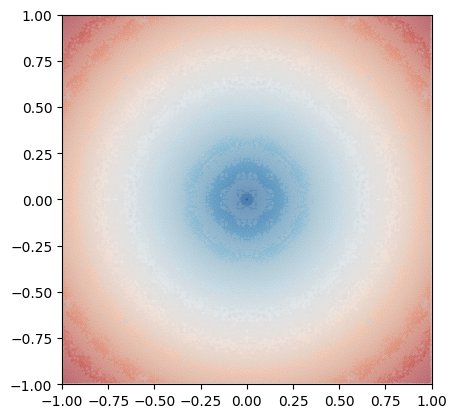

In [26]:
plot_DU(DU_sg_qoi)

In [27]:
U = np.exp(4 * X + 3 * Y)

In [28]:
DU = U * 25

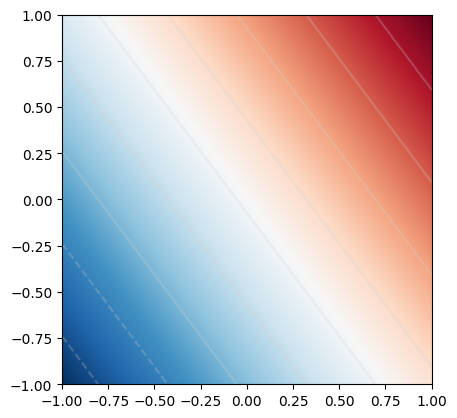

In [29]:
plot_DU(np.log(DU))

In [30]:
DU_np = np.gradient(np.gradient(U, axis=0), axis=0) + np.gradient(
    np.gradient(U, axis=1), axis=1
)

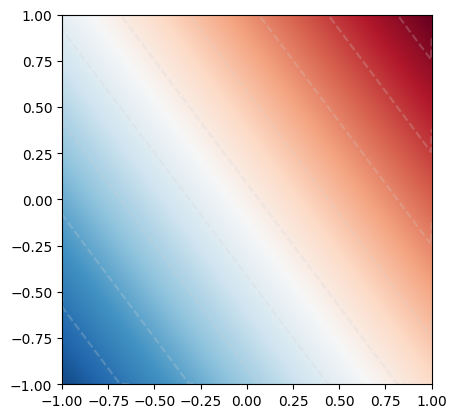

In [31]:
plot_DU(np.log(DU_np))

In [32]:
zfp = Zfp(mode="fixed-rate", rate=5.5)

In [33]:
U_zfp = zfp.decode(zfp.encode(U))

In [34]:
DU_zfp = np.gradient(np.gradient(U_zfp, axis=0), axis=0) + np.gradient(
    np.gradient(U_zfp, axis=1), axis=1
)

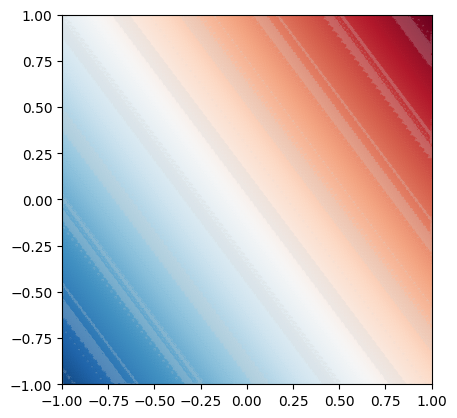

In [35]:
plot_DU(np.log(DU_zfp))

In [36]:
np.amax(np.abs(U_zfp - U))

np.float64(0.0315610340890089)

In [37]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(kind="eb", type="abs", eb=0.03),
    ],
)

In [38]:
U_sg = sg.decode(sg.encode(U))

In [39]:
DU_sg = np.gradient(np.gradient(U_sg, axis=0), axis=0) + np.gradient(
    np.gradient(U_sg, axis=1), axis=1
)

/tmp/ipykernel_37498/4048621075.py:1: RuntimeWarning: divide by zero encountered in log
  plot_DU(np.log(DU_sg))
/tmp/ipykernel_37498/4048621075.py:1: RuntimeWarning: invalid value encountered in log
  plot_DU(np.log(DU_sg))


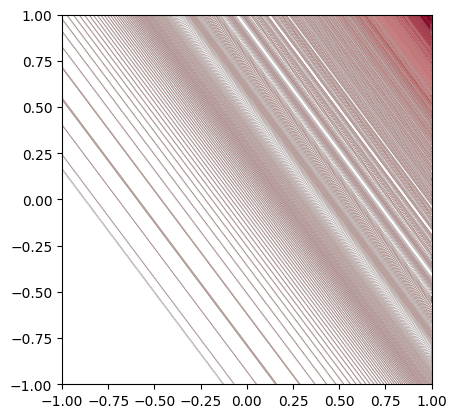

In [40]:
plot_DU(np.log(DU_sg))

In [41]:
sg_qoi = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="ln(findiff(x, order=2, accuracy=2, type=0, dx=2/1023, axis=0)+findiff(x, order=2, accuracy=2, type=0, dx=2/1023, axis=1))",
            neighbourhood=[
                dict(axis=0, before=1, after=1, boundary="edge"),
                dict(axis=1, before=1, after=1, boundary="edge"),
            ],
            type="abs",
            eb=1.0,
        ),
    ],
)

In [42]:
sg_qoi._safeguards.safeguards[0]._qoi_expr

log(1046529*X[0, 1]/4 + 1046529*X[1, 0]/4 - 1046529*X[1, 1] + 1046529*X[1, 2]/4 + 1046529*X[2, 1]/4)

In [43]:
U_sg_qoi = sg_qoi.decode(sg_qoi.encode(U))

In [44]:
DU_sg_qoi = np.gradient(np.gradient(U_sg_qoi, axis=0), axis=0) + np.gradient(
    np.gradient(U_sg_qoi, axis=1), axis=1
)

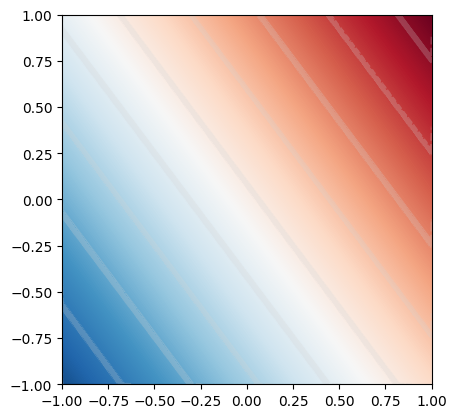

In [45]:
plot_DU(np.log(DU_sg_qoi))